Iñigo Martin Melero

## Participante 4

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_24_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


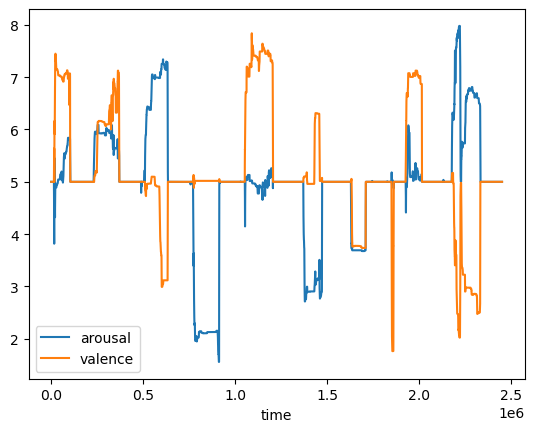

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_24_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.925  36.989   7.909  32.885  28.071    11.027     9.630   
1              1  0.938  37.115   7.893  32.895  28.068    10.822     9.588   
2              2  0.951  37.241   7.878  32.905  28.064    10.617     9.547   
3              3  0.964  37.319   7.897  32.934  28.085    10.737     9.710   
4              4  0.945  36.850   7.975  32.895  28.068    10.575     9.670   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.711  36.234  11.572  33.157  24.941     5.933     7.371   
2451580  2451580  0.715  35.996  11.611  33.137  24.941     5.811     7.330   
2451581  2451581  0.711  36.127  11.475  33.166  24.944     5.891     7.410   
2451582  2451582  0.715  36.263  11.582  33.176  24.958     6.054     7.615   
2451583  2451583  0.734  36.341  11.607  33.166  24.941     5.893     7.535   

         emg_trap  video  
0           9.095     10

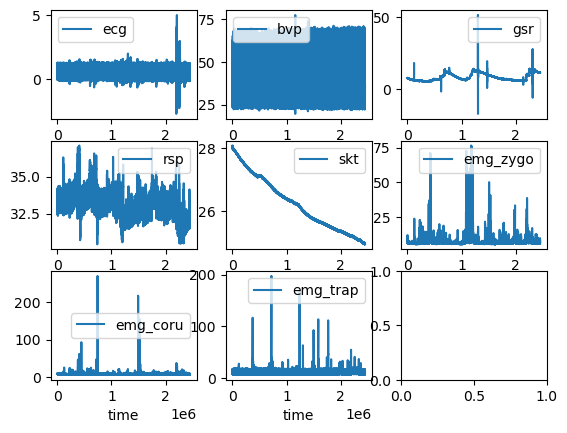

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

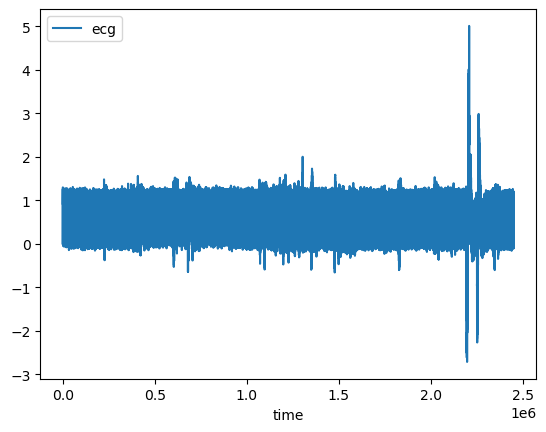

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

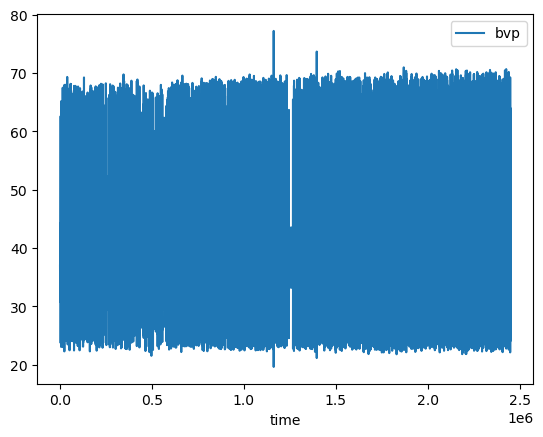

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

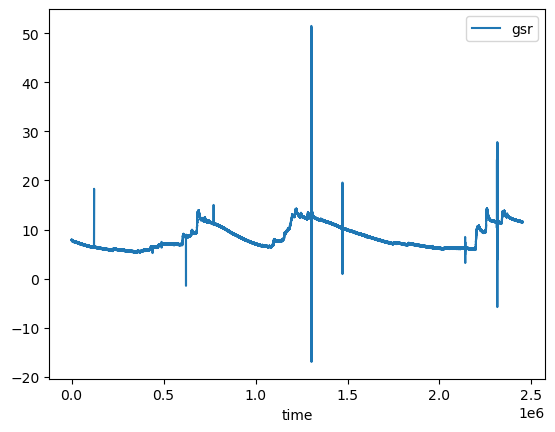

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

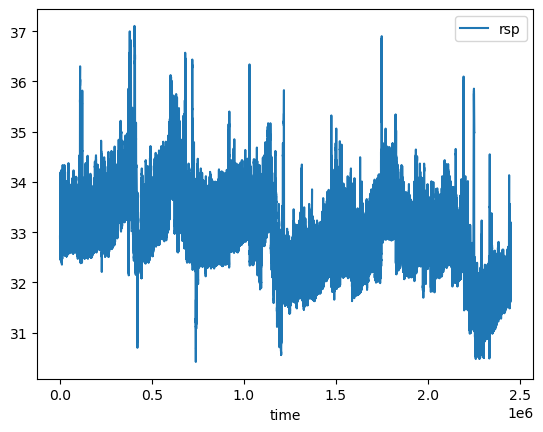

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

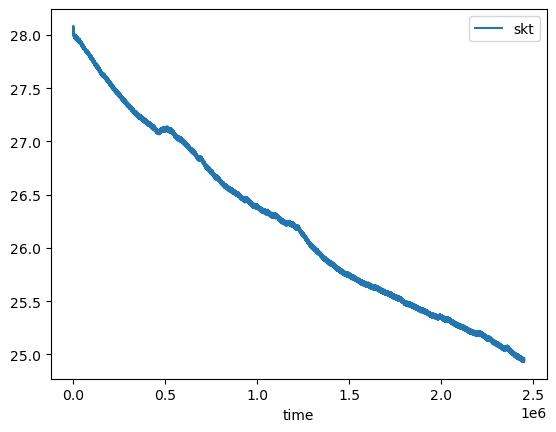

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

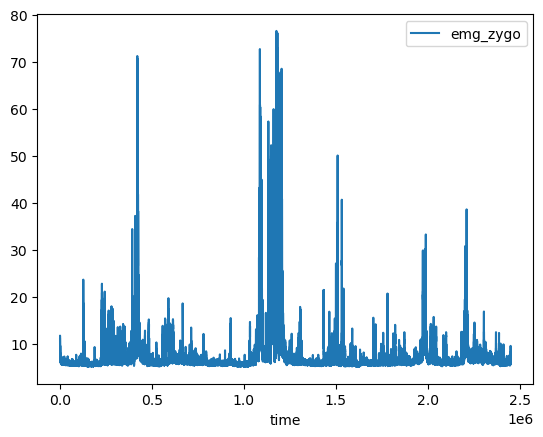

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

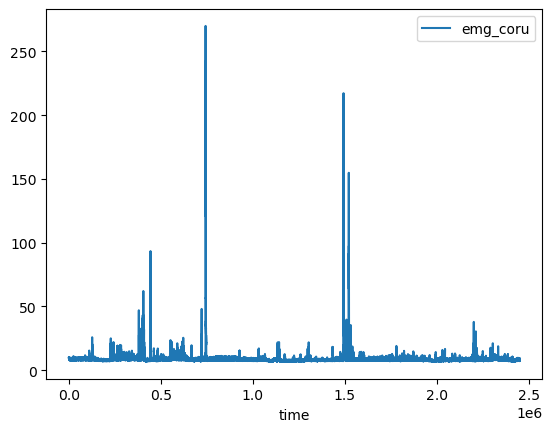

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

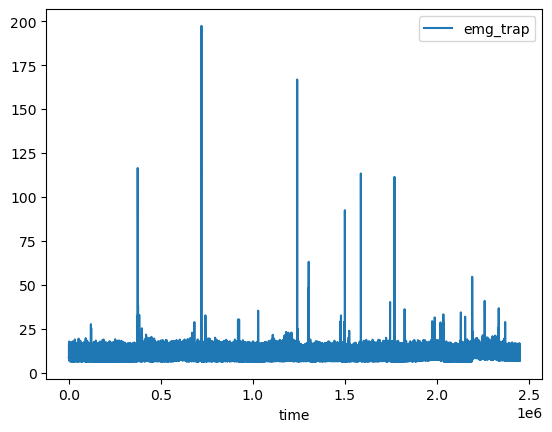

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

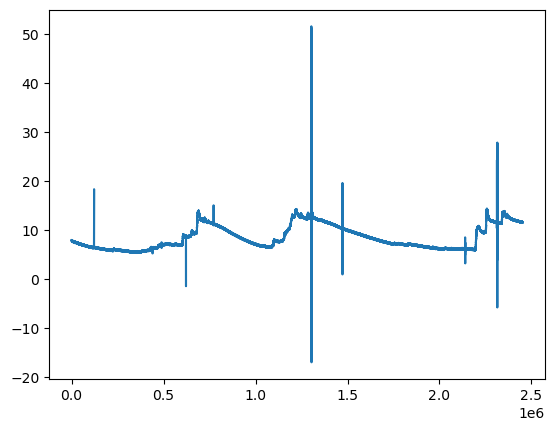

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

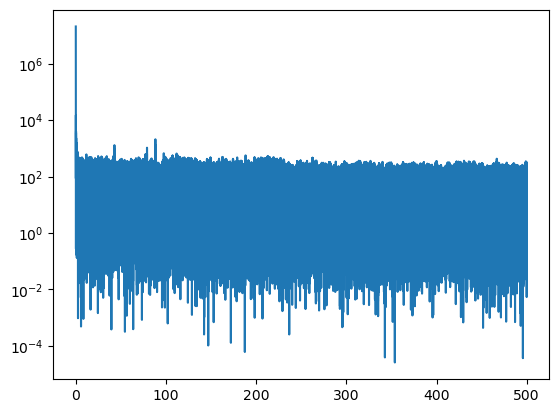

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

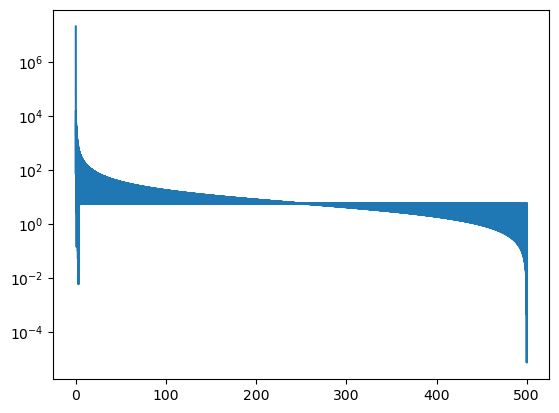

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

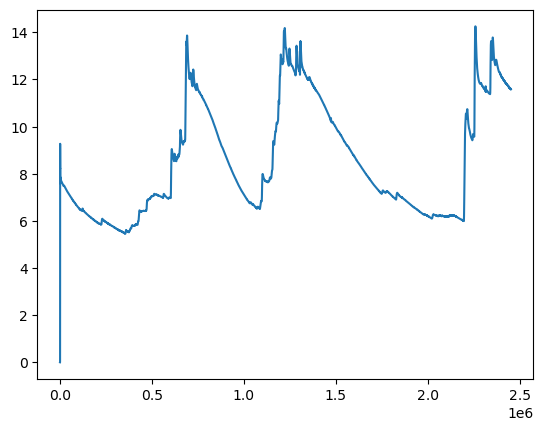

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  11.575
2451580  11.575
2451581  11.575
2451582  11.575
2451583  11.574

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

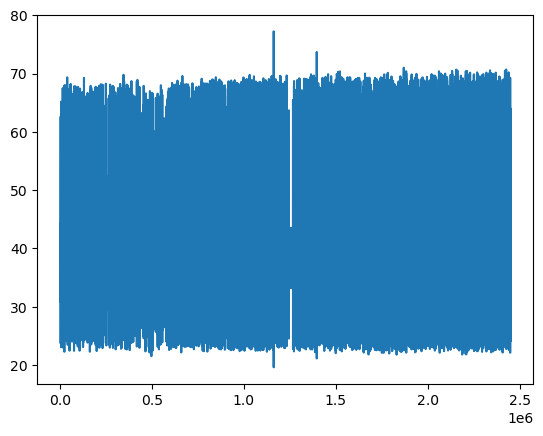

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

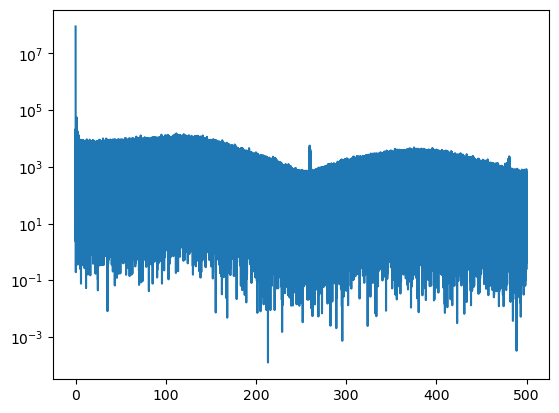

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

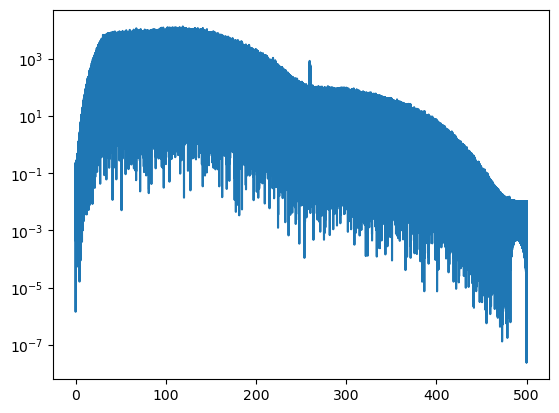

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

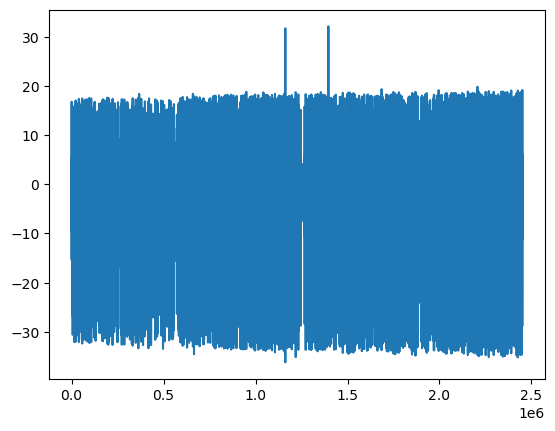

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.028
1        42.737
2        50.513
3        53.748
4        46.432
...         ...
2451579  37.115
2451580  37.138
2451581  37.133
2451582  37.081
2451583  37.032

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

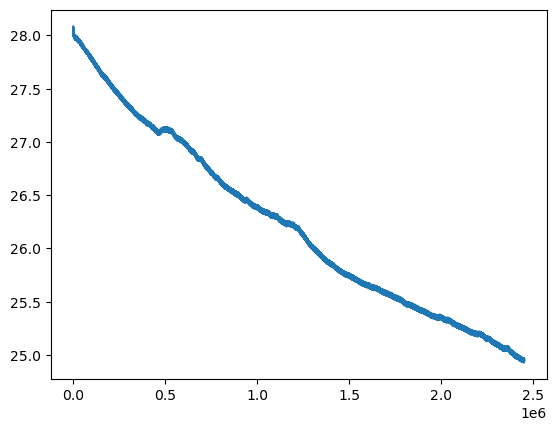

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

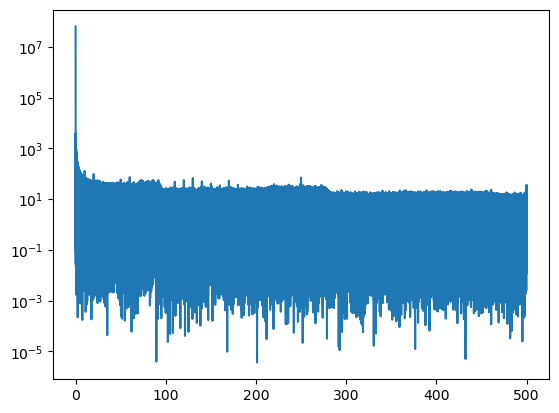

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

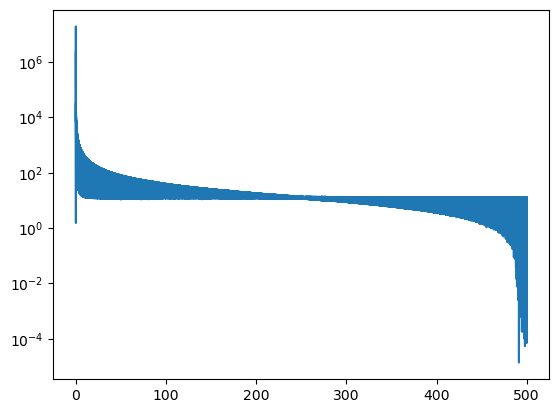

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

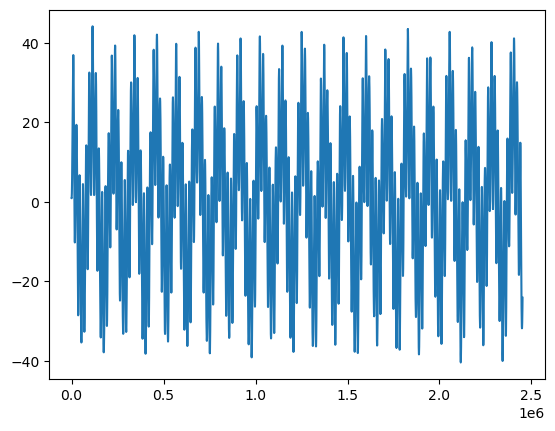

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.900
1        40.899
2        40.899
3        40.900
4        40.899
...         ...
2451579  15.850
2451580  15.855
2451581  15.859
2451582  15.864
2451583  15.868

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.925  32.885    11.027     9.630     9.095     10
1              1  0.938  32.895    10.822     9.588     9.095     10
2              2  0.951  32.905    10.617     9.547     9.095     10
3              3  0.964  32.934    10.737     9.710     9.136     10
4              4  0.945  32.895    10.575     9.670     9.136     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.711  33.157     5.933     7.371     7.822     12
2451580  2451580  0.715  33.137     5.811     7.330     7.741     12
2451581  2451581  0.711  33.166     5.891     7.410     7.862     12
2451582  2451582  0.715  33.176     6.054     7.615     8.066     12
2451583  2451583  0.734  33.166     5.893     7.535     7.946     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.925  32.885    11.027     9.630     9.095     10  38.028   
1              1  0.938  32.895    10.822     9.588     9.095     10  42.737   
2              2  0.951  32.905    10.617     9.547     9.095     10  50.513   
3              3  0.964  32.934    10.737     9.710     9.136     10  53.748   
4              4  0.945  32.895    10.575     9.670     9.136     10  46.432   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.711  33.157     5.933     7.371     7.822     12  37.115   
2451580  2451580  0.715  33.137     5.811     7.330     7.741     12  37.138   
2451581  2451581  0.711  33.166     5.891     7.410     7.862     12  37.133   
2451582  2451582  0.715  33.176     6.054     7.615     8.066     12  37.081   
2451583  2451583  0.734  33.166     5.893     7.535     7.946     12  37.032   

            gsr     skt  
0         0.000  40.900  
1         0.000  40.899  
2         0.000  40.899  
3         0.000  40.900  
4         0.000  40.899  
...         ...     ...  
2451579  11.575  15.850  
2451580  11.575  15.855  
2451581  11.575  15.859  
2451582  11.575  15.864  
2451583  11.574  15.868  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.470687  0.531613  0.045703  0.793434  0.411005  0.006284   
221502    221502  0.473534  0.532140  0.045703  0.793360  0.412774  0.007431   
221503    221503  0.473664  0.531687  0.045703  0.793285  0.411005  0.007445   
221504    221504  0.475346  0.531115  0.045703  0.793210  0.414367  0.006885   
221505    221505  0.476640  0.531452  0.045703  0.793136  0.417905  0.008579   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.468487  0.529227  0.677467  0.356501  0.166136  0.021790   
2331580  2331580  0.467711  0.529695  0.677467  0.356588  0.161005  0.019537   
2331581  2331581  0.464346  0.530588  0.677467  0.356663  0.161005  0.020656   
2331582  2331582  0.465122  0.530559  0.677467  0.356750  0.164367  0.021244   
2331583  2331583  0.465899  0.530281  0.677467  0.356837  0.164367  0.021818   

         emg_coru  emg_trap  video  
221501   0.026242  0.015244      6  
221502   0.028870  0.016938      6  
221503   0.028870  0.016111      6  
221504   0.030184  0.017784      6  
221505   0.030184  0.017805      6  
...           ...       ...    ...  
2331579  0.098625  0.062731      7  
2331580  0.093403  0.061926      7  
2331581  0.092057  0.061079      7  
2331582  0.092057  0.061905      7  
2331583  0.089461  0.061079      7  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.470687  0.531613  0.045703  0.411005  0.793434  0.006284   
221502    221502  0.473534  0.532140  0.045703  0.412774  0.793360  0.007431   
221503    221503  0.473664  0.531687  0.045703  0.411005  0.793285  0.007445   
221504    221504  0.475346  0.531115  0.045703  0.414367  0.793210  0.006885   
221505    221505  0.476640  0.531452  0.045703  0.417905  0.793136  0.008579   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.468487  0.529227  0.677467  0.166136  0.356501  0.021790   
2331580  2331580  0.467711  0.529695  0.677467  0.161005  0.356588  0.019537   
2331581  2331581  0.464346  0.530588  0.677467  0.161005  0.356663  0.020656   
2331582  2331582  0.465122  0.530559  0.677467  0.164367  0.356750  0.021244   
2331583  2331583  0.465899  0.530281  0.677467  0.164367  0.356837  0.021818   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
221540   0.479099  0.530720  0.045816  0.411005  0.790447  0.008593  0.021020   
221560   0.487252  0.531569  0.045816  0.416136  0.788915  0.009167  0.028902   
221580   0.499159  0.530090  0.045816  0.411005  0.787372  0.008593  0.023615   
221600   0.505500  0.529754  0.045816  0.409413  0.785841  0.007445  0.026242   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.454898  0.530574  0.677467  0.135350  0.349940  0.020670  0.109199   
2331520  0.456193  0.530090  0.677467  0.143843  0.351608  0.018389  0.089397   
2331540  0.458651  0.530105  0.677467  0.148974  0.353264  0.014946  0.122369   
2331560  0.463440  0.531072  0.677467  0.159236  0.354920  0.018375  0.118395   
2331580  0.467711  0.529695  0.677467  0.161005  0.356588  0.019537  0.093403   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1      0.479099  0.530720  0.045816  0.411005  0.790447  0.008593  0.021020   
2      0.487252  0.531569  0.045816  0.416136  0.788915  0.009167  0.028902   
3      0.499159  0.530090  0.045816  0.411005  0.787372  0.008593  0.023615   
4      0.505500  0.529754  0.045816  0.409413  0.785841  0.007445  0.026242   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.454898  0.530574  0.677467  0.135350  0.349940  0.020670  0.109199   
63500  0.456193  0.530090  0.677467  0.143843  0.351608  0.018389  0.089397   
63501  0.458651  0.530105  0.677467  0.148974  0.353264  0.014946  0.122369   
63502  0.463440  0.531072  0.677467  0.159236  0.354920  0.018375  0.118395   
63503  0.467711  0.529695  0.677467  0.161005  0.356588  0.019537  0.093403   

       emg_trap  valence  arousal  
0      0.020325    5.000    5.000  
1      0.023754    5.000    5.000  
2      0.027121    5.000    5.000  
3      0.023754    5.000    5.000  
4      0.017805    5.000    5.000  
...         ...      ...      ...  
63499  0.051742    2.567    6.463  
63500  0.076322    2.567    6.463  
63501  0.062772    2.567    6.463  
63502  0.064446    2.566    6.463  
63503  0.061926    2.567    6.463  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1      0.479099  0.530720  0.045816  0.411005  0.790447  0.008593  0.021020   
2      0.487252  0.531569  0.045816  0.416136  0.788915  0.009167  0.028902   
3      0.499159  0.530090  0.045816  0.411005  0.787372  0.008593  0.023615   
4      0.505500  0.529754  0.045816  0.409413  0.785841  0.007445  0.026242   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.457098  0.530837  0.677581  0.116596  0.343280  0.019551  0.093435   
63496  0.457875  0.529095  0.677581  0.128450  0.344948  0.020083  0.157807   
63497  0.456193  0.530369  0.677467  0.128450  0.346604  0.020097  0.157839   
63498  0.454898  0.543386  0.677467  0.136943  0.348285  0.022364  0.123586   
63499  0.454898  0.530574  0.677467  0.135350  0.349940  0.020670  0.109199   

       emg_trap  valence  arousal  
0      0.020325    5.000    5.000  
1      0.023754    5.000    5.000  
2      0.027121    5.000    5.000  
3      0.023754    5.000    5.000  
4      0.017805    5.000    5.000  
...         ...      ...      ...  
63495  0.043274    2.567    6.463  
63496  0.054304    2.567    6.463  
63497  0.045773    2.566    6.463  
63498  0.056803    2.567    6.463  
63499  0.051742    2.567    6.463  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
 1   0.479099  0.530720  0.045816  0.411005  0.790447  0.008593  0.021020   
 2   0.487252  0.531569  0.045816  0.416136  0.788915  0.009167  0.028902   
 3   0.499159  0.530090  0.045816  0.411005  0.787372  0.008593  0.023615   
 4   0.505500  0.529754  0.045816  0.409413  0.785841  0.007445  0.026242   
 5   0.503818  0.529241  0.045816  0.412774  0.784284  0.008593  0.026274   
 6   0.484664  0.531115  0.045816  0.402512  0.782741  0.005150  0.031529   
 7   0.466416  0.530149  0.045816  0.404282  0.781197  0.004017  0.035471   
 8   0.457487  0.532960  0.045703  0.407643  0.779653  0.005150  0.034157   
 9   0.454898  0.527879  0.045703  0.407643  0.778097  0.005150  0.024961   
 10  0.453992  0.532550  0.045703  0.414544  0.776554  0.005738  0.026242   
 11  0.455287  0.529417  0.045703  0.407643  0.774998  0.005150  0.026242   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1     0.451145  0.530720  0.045589  0.407643  0.753087  0.012609  0.046012   
2     0.466805  0.540267  0.045362  0.411005  0.713973  0.016080  0.039444   
3     0.446357  0.529153  0.044793  0.604565  0.675941  0.019509  0.045980   
4     0.470687  0.530076  0.044679  0.762208  0.640125  0.017801  0.059150   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.447651  0.543415  0.680082  0.311748  0.165260  0.032734  0.094652   
2536  0.454122  0.527660  0.679627  0.174628  0.195374  0.028130  0.081547   
2537  0.468099  0.530823  0.679059  0.130219  0.230268  0.021804  0.110449   
2538  0.455804  0.535201  0.678490  0.109696  0.268885  0.018949  0.095966   
2539  0.490617  0.530779  0.678263  0.113057  0.309867  0.023525  0.119645   

             8         9        10  ...       193       194       195  \
0     0.020325  0.479099  0.530720  ...  0.451922  0.529783  0.045589   
1     0.018652  0.450628  0.572803  ...  0.465122  0.530603  0.045248   
2     0.045793  0.470687  0.528509  ...  0.444675  0.530823  0.044793   
3     0.011856  0.442992  0.526986  ...  0.463440  0.531101  0.044679   
4     0.018631  0.477029  0.528524  ...  0.462146  0.528612  0.044338   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.256171  0.452310  0.526649  ...  0.455416  0.530954  0.679627   
2536  0.064466  0.454122  0.532067  ...  0.467193  0.529651  0.679059   
2537  0.061926  0.471981  0.530486  ...  0.455804  0.528187  0.678490   
2538  0.064466  0.458263  0.531643  ...  0.482982  0.530515  0.678263   
2539  0.061017  0.501747  0.530295  ...  0.454898  0.530574  0.677467   

           196       197       198       199       200  valence  arousal  
0     0.405874  0.754656  0.011476  0.044635  0.016938  5.00000  5.00000  
1     0.412774  0.715529  0.014359  0.038098  0.053436  5.00000  5.00000  
2     0.594303  0.677435  0.016066  0.032811  0.016091  5.00000  5.00000  
3     0.758669  0.641495  0.015492  0.047294  0.016958  5.00000  5.00000  
4     0.529193  0.608667  0.016066  0.060463  0.024580  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.169674  0.194054  0.020083  0.099907  0.073782  2.50000  6.49800  
2536  0.133581  0.228799  0.019509  0.105194  0.068721  2.50000  6.49668  
2537  0.113057  0.267292  0.020684  0.084174  0.083098  2.50000  6.48764  
2538  0.106157  0.308199  0.021272  0.098657  0.055977  2.50412  6.48628  
2539  0.135350  0.349940  0.020670  0.109199  0.051742  2.54796  6.46896  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1     0.451145  0.530720  0.045589  0.407643  0.753087  0.012609  0.046012   
2     0.466805  0.540267  0.045362  0.411005  0.713973  0.016080  0.039444   
3     0.446357  0.529153  0.044793  0.604565  0.675941  0.019509  0.045980   
4     0.470687  0.530076  0.044679  0.762208  0.640125  0.017801  0.059150   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.447651  0.543415  0.680082  0.311748  0.165260  0.032734  0.094652   
2536  0.454122  0.527660  0.679627  0.174628  0.195374  0.028130  0.081547   
2537  0.468099  0.530823  0.679059  0.130219  0.230268  0.021804  0.110449   
2538  0.455804  0.535201  0.678490  0.109696  0.268885  0.018949  0.095966   
2539  0.490617  0.530779  0.678263  0.113057  0.309867  0.023525  0.119645   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub24.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1     0.451145  0.530720  0.045589  0.407643  0.753087  0.012609  0.046012   
2     0.466805  0.540267  0.045362  0.411005  0.713973  0.016080  0.039444   
3     0.446357  0.529153  0.044793  0.604565  0.675941  0.019509  0.045980   
4     0.470687  0.530076  0.044679  0.762208  0.640125  0.017801  0.059150   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.447651  0.543415  0.680082  0.311748  0.165260  0.032734  0.094652   
2536  0.454122  0.527660  0.679627  0.174628  0.195374  0.028130  0.081547   
2537  0.468099  0.530823  0.679059  0.130219  0.230268  0.021804  0.110449   
2538  0.455804  0.535201  0.678490  0.109696  0.268885  0.018949  0.095966   
2539  0.490617  0.530779  0.678263  0.113057  0.309867  0.023525  0.119645   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub24.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1     0.451145  0.530720  0.045589  0.407643  0.753087  0.012609  0.046012   
2     0.466805  0.540267  0.045362  0.411005  0.713973  0.016080  0.039444   
3     0.446357  0.529153  0.044793  0.604565  0.675941  0.019509  0.045980   
4     0.470687  0.530076  0.044679  0.762208  0.640125  0.017801  0.059150   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.447651  0.543415  0.680082  0.311748  0.165260  0.032734  0.094652   
2536  0.454122  0.527660  0.679627  0.174628  0.195374  0.028130  0.081547   
2537  0.468099  0.530823  0.679059  0.130219  0.230268  0.021804  0.110449   
2538  0.455804  0.535201  0.678490  0.109696  0.268885  0.018949  0.095966   
2539  0.490617  0.530779  0.678263  0.113057  0.309867  0.023525  0.119645   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub24.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1     0.451145  0.530720  0.045589  0.407643  0.753087  0.012609  0.046012   
2     0.466805  0.540267  0.045362  0.411005  0.713973  0.016080  0.039444   
3     0.446357  0.529153  0.044793  0.604565  0.675941  0.019509  0.045980   
4     0.470687  0.530076  0.044679  0.762208  0.640125  0.017801  0.059150   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.447651  0.543415  0.680082  0.311748  0.165260  0.032734  0.094652   
2536  0.454122  0.527660  0.679627  0.174628  0.195374  0.028130  0.081547   
2537  0.468099  0.530823  0.679059  0.130219  0.230268  0.021804  0.110449   
2538  0.455804  0.535201  0.678490  0.109696  0.268885  0.018949  0.095966   
2539  0.490617  0.530779  0.678263  0.113057  0.309867  0.023525  0.119645   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub24.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.476123  0.528626  0.045703  0.414544  0.791978  0.008593  0.026242   
1     0.451145  0.530720  0.045589  0.407643  0.753087  0.012609  0.046012   
2     0.466805  0.540267  0.045362  0.411005  0.713973  0.016080  0.039444   
3     0.446357  0.529153  0.044793  0.604565  0.675941  0.019509  0.045980   
4     0.470687  0.530076  0.044679  0.762208  0.640125  0.017801  0.059150   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.447651  0.543415  0.680082  0.311748  0.165260  0.032734  0.094652   
2536  0.454122  0.527660  0.679627  0.174628  0.195374  0.028130  0.081547   
2537  0.468099  0.530823  0.679059  0.130219  0.230268  0.021804  0.110449   
2538  0.455804  0.535201  0.678490  0.109696  0.268885  0.018949  0.095966   
2539  0.490617  0.530779  0.678263  0.113057  0.309867  0.023525  0.119645   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub24.csv', index=False)